In [2]:
#Load UNSW_NB15
import pandas as pd

train_path = "../data/raw/UNSW_NB15/UNSW_NB15_testing-set.parquet"
test_path  = "../data/raw/UNSW_NB15/UNSW_NB15_training-set.parquet"

In [3]:
df_train = pd.read_parquet(train_path)
df_test  = pd.read_parquet(test_path)

print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)
df_train.head()

Train shape: (82332, 36)
Test shape: (175341, 36)


,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sload,...,trans_depth,response_body_len,ct_src_dport_ltm,ct_dst_sport_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,is_sm_ips_ports,attack_cat,label
0,0.000011,udp,-,INT,2,0,496,0,90909.09375,180363632.0,...,0,0,1,1,0,0,0,0,Normal,0
1,0.000008,udp,-,INT,2,0,1762,0,125000.00000,881000000.0,...,0,0,1,1,0,0,0,0,Normal,0
2,0.000005,udp,-,INT,2,0,1068,0,200000.00000,854400000.0,...,0,0,1,1,0,0,0,0,Normal,0
3,0.000006,udp,-,INT,2,0,900,0,166666.65625,600000000.0,...,0,0,2,1,0,0,0,0,Normal,0
4,0.000010,udp,-,INT,2,0,2126,0,100000.00000,850400000.0,...,0,0,2,1,0,0,0,0,Normal,0


In [4]:
#Identify Target Columns
print(df_train.columns)

Index(['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt',
       'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt',
       'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'is_sm_ips_ports',
       'attack_cat', 'label'],
      dtype='object')


In [5]:
df_train["label"].value_counts()

label
1    45332
0    37000
Name: count, dtype: int64

In [6]:
#Seperate Features and Target
X_train = df_train.drop(["label", "attack_cat"], axis=1)
y_train = df_train["label"]

X_test = df_test.drop(["label", "attack_cat"], axis=1)
y_test = df_test["label"]

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
numeric_cols = X_train.select_dtypes(exclude=['object', 'category']).columns

print("Categorical:", categorical_cols)
print("Numeric:", numeric_cols)

Categorical: Index(['proto', 'service', 'state'], dtype='object')
Numeric: Index(['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sload', 'dload',
       'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb',
       'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean',
       'trans_depth', 'response_body_len', 'ct_src_dport_ltm',
       'ct_dst_sport_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd',
       'is_sm_ips_ports'],
      dtype='object')


In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

In [9]:
from sklearn.ensemble import RandomForestClassifier

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ))
])


In [10]:
model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [11]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

print("\nROC-AUC Score:", roc_auc_score(y_test, y_proba))


Accuracy: 0.9088861133448537

Classification Report:

              precision    recall  f1-score   support

           0       0.79      0.96      0.87     56000
           1       0.98      0.88      0.93    119341

    accuracy                           0.91    175341
   macro avg       0.89      0.92      0.90    175341
weighted avg       0.92      0.91      0.91    175341


Confusion Matrix:

[[ 54032   1968]
 [ 14008 105333]]

ROC-AUC Score: 0.985167348336759


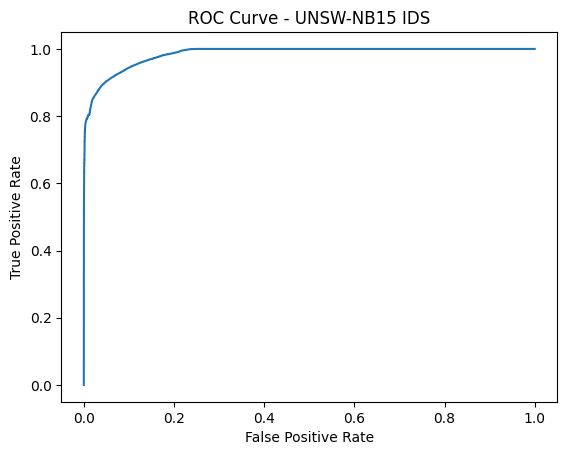

In [12]:
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - UNSW-NB15 IDS")
plt.show()

In [13]:
print(X_train.columns)

Index(['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt',
       'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt',
       'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'is_sm_ips_ports'],
      dtype='object')


In [14]:
import joblib
joblib.dump(model, "../models/unsw_rf_model.pkl")
print("Model saved successfully.")

Model saved successfully.


In [15]:
print(dir())

['ColumnTransformer', 'In', 'OneHotEncoder', 'Out', 'Pipeline', 'RandomForestClassifier', 'StandardScaler', 'X_test', 'X_train', '_', '_10', '_3', '_5', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__session__', '__spec__', '_dh', '_i', '_i1', '_i10', '_i11', '_i12', '_i13', '_i14', '_i15', '_i2', '_i3', '_i4', '_i5', '_i6', '_i7', '_i8', '_i9', '_ih', '_ii', '_iii', '_oh', 'accuracy_score', 'categorical_cols', 'classification_report', 'confusion_matrix', 'df_test', 'df_train', 'exit', 'fpr', 'get_ipython', 'joblib', 'model', 'numeric_cols', 'open', 'pd', 'plt', 'preprocessor', 'quit', 'roc_auc_score', 'roc_curve', 'test_path', 'tpr', 'train_path', 'y_pred', 'y_proba', 'y_test', 'y_train']


In [16]:
import shap
import numpy as np

In [17]:
rf_model = model.named_steps["classifier"]
preprocessor = model.named_steps["preprocessor"]

In [18]:
#Transform data
X_train_processed = preprocessor.transform(X_train)
X_test_processed  = preprocessor.transform(X_test)

print("Transformation complete")


Transformation complete


In [19]:
import numpy as np

X_train_transformed = preprocessor.transform(X_train)

# Convert to numpy array if sparse
if hasattr(X_train_transformed, "toarray"):
    X_train_transformed = X_train_transformed.toarray()

# Force numeric dtype
X_train_transformed = X_train_transformed.astype(np.float32)

X_sample = X_train_transformed[:500] 

In [20]:
#create SHAP Explainer
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_sample)

In [21]:
print("X_sample shape:", X_sample.shape)
print("SHAP shape:", np.array(shap_values).shape)

X_sample shape: (500, 182)
SHAP shape: (500, 182, 2)


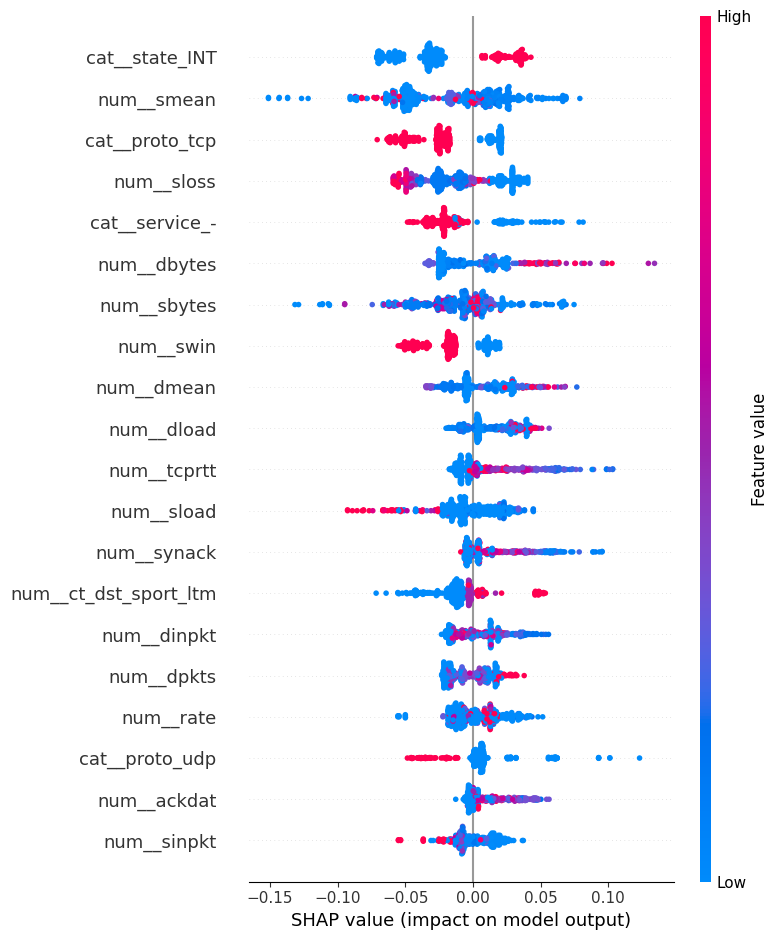

In [22]:
feature_names = preprocessor.get_feature_names_out()

shap.summary_plot(
    shap_values[:, :, 1],
    X_sample,
    feature_names=feature_names
)


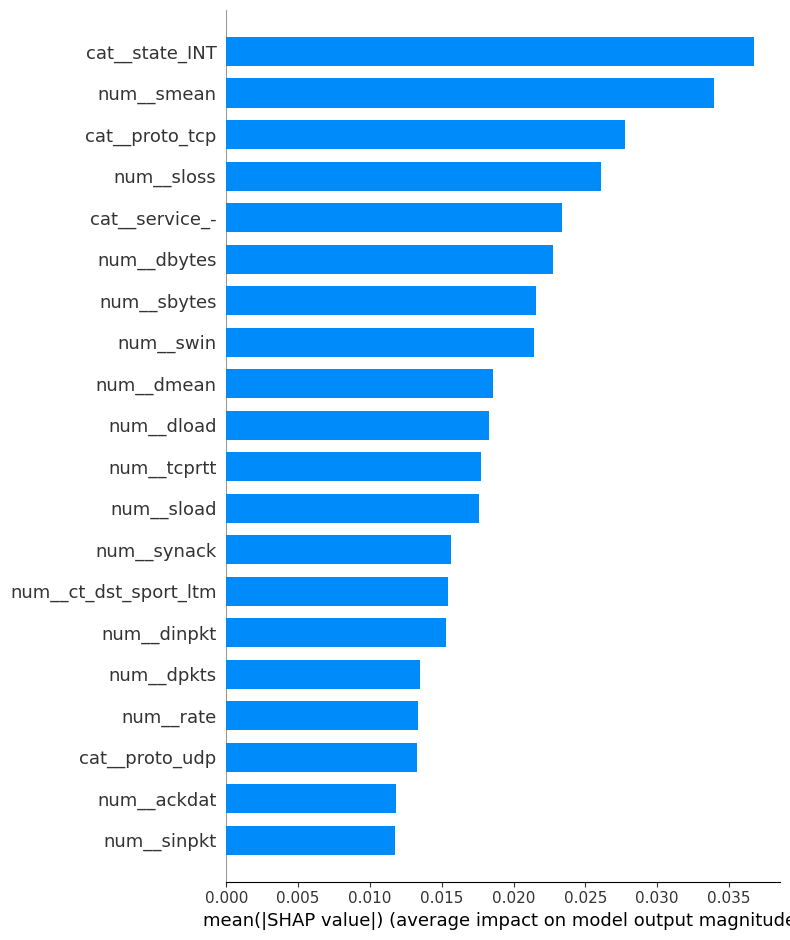

In [23]:
shap.summary_plot(
    shap_values[:, :, 1],
    X_sample,
    feature_names=feature_names,
    plot_type="bar"
)

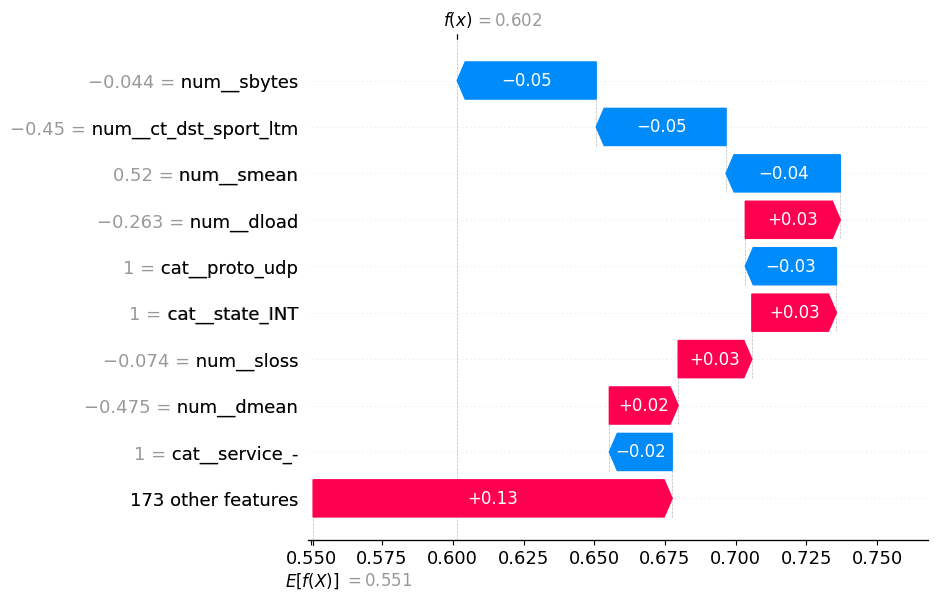

In [24]:
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[0, :, 1],
        base_values=explainer.expected_value[1],
        data=X_sample[0],
        feature_names=feature_names
    )
)

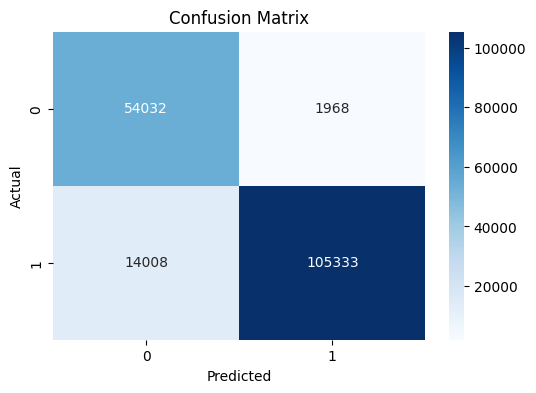

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [26]:
import joblib
joblib.dump(model, "../models/unsw_rf_model.pkl")
print("Model saved successfully.")

Model saved successfully.


In [27]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [28]:
from xgboost import XGBClassifier

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric="logloss",
        n_jobs=-1
    ))
])

In [29]:
model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [30]:
y_probs = model.predict_proba(X_test)[:, 1]

In [31]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt

threshold = 0.35   # try 0.3 to 0.45
y_pred = (y_probs >= threshold).astype(int)
y_proba = model.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

print("\nROC-AUC Score:", roc_auc_score(y_test, y_proba))


Accuracy: 0.9231041228235267

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.94      0.89     56000
           1       0.97      0.92      0.94    119341

    accuracy                           0.92    175341
   macro avg       0.90      0.93      0.91    175341
weighted avg       0.93      0.92      0.92    175341


Confusion Matrix:

[[ 52599   3401]
 [ 10082 109259]]

ROC-AUC Score: 0.9854416716443994


In [32]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import numpy as np

In [33]:
param_dist = {
    "classifier__n_estimators": [200, 300, 400, 500],
    "classifier__max_depth": [4, 6, 8, 10],
    "classifier__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "classifier__subsample": [0.7, 0.8, 0.9, 1.0],
    "classifier__colsample_bytree": [0.7, 0.8, 0.9, 1.0],
    "classifier__scale_pos_weight": [1, 2, 3]
}

In [34]:
random_search = RandomizedSearchCV(
    model,                      # your Pipeline
    param_distributions=param_dist,
    n_iter=20,                  # number of random combinations
    scoring="recall",           # IMPORTANT: optimize for attack detection
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

In [35]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


,estimator,"Pipeline(step...=None, ...))])"
,param_distributions,"{'classifier__colsample_bytree': [0.7, 0.8, ...], 'classifier__learning_rate': [0.01, 0.05, ...], 'classifier__max_depth': [4, 6, ...], 'classifier__n_estimators': [200, 300, ...], ...}"
,n_iter,20
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [36]:
best_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

Best Parameters: {'classifier__subsample': 0.7, 'classifier__scale_pos_weight': 3, 'classifier__n_estimators': 500, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.01, 'classifier__colsample_bytree': 0.8}


In [37]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

print("Accuracy:", best_model.score(X_test, y_test))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

print("\nROC-AUC Score:", roc_auc_score(y_test, y_proba))

Accuracy: 0.9298737887887032

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.87      0.89     56000
           1       0.94      0.96      0.95    119341

    accuracy                           0.93    175341
   macro avg       0.92      0.92      0.92    175341
weighted avg       0.93      0.93      0.93    175341


Confusion Matrix:
 [[ 48953   7047]
 [  5249 114092]]

ROC-AUC Score: 0.9841808840543365


In [38]:
import joblib
joblib.dump(model, "unsw_nb15_rf_binary.pkl")
print("Model saved successfully ✅")

Model saved successfully ✅


In [39]:
y = df_train["attack_cat"]
y.value_counts()

attack_cat
Normal            37000
Generic           18871
Exploits          11132
Fuzzers            6062
DoS                4089
Reconnaissance     3496
Analysis            677
Backdoor            583
Shellcode           378
Worms                44
Name: count, dtype: int64

In [40]:
from sklearn.ensemble import RandomForestClassifier

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=200,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])
model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [41]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_train = le.fit_transform(df_train["attack_cat"])
y_test  = le.transform(df_test["attack_cat"])


In [42]:
RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [43]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred,target_names=le.classes_))

                precision    recall  f1-score   support

      Analysis       0.01      0.27      0.02      2000
      Backdoor       0.02      0.99      0.03      1746
           DoS       0.00      0.00      0.00     12264
      Exploits       0.00      0.00      0.00     33393
       Fuzzers       0.00      0.00      0.00     18184
       Generic       0.00      0.00      0.00     40000
        Normal       0.00      0.00      0.00     56000
Reconnaissance       0.00      0.00      0.00     10491
     Shellcode       0.00      0.00      0.00      1133
         Worms       0.00      0.00      0.00       130

      accuracy                           0.01    175341
     macro avg       0.00      0.13      0.00    175341
  weighted avg       0.00      0.01      0.00    175341



D:\Anaconda\envs\ai-ids\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\Anaconda\envs\ai-ids\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\Anaconda\envs\ai-ids\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [44]:
import joblib

joblib.dump(model, "unsw_multiclass_model.pkl")
joblib.dump(preprocessor, "preprocessor.pkl")
joblib.dump(le, "label_encoder.pkl")


['label_encoder.pkl']

In [45]:
X_test.sample(20).to_csv("sample_test.csv", index=False)